In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
plant = load_model('plant_tahap1.h5')
plant.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [3]:
control = load_model('control_tahap1.h5')
control.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


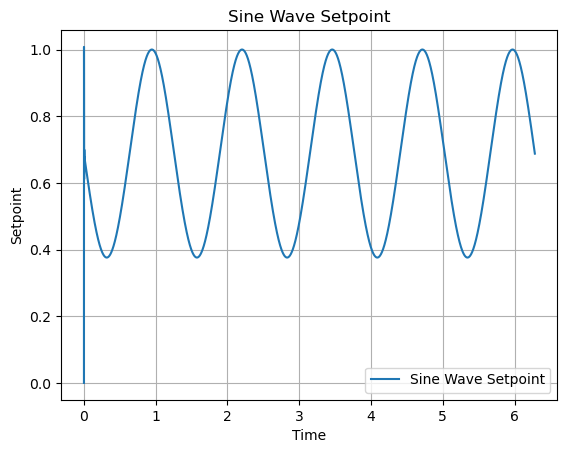

In [7]:
k_max = 10000

# Generate a sine wave input
sine_wave_length = 10000
sine_wave_t = np.linspace(0, 2 * np.pi, sine_wave_length)
sine_wave_u = 10 * np.sin(5 * sine_wave_t)

# Initialize y(k) array for sine wave
sine_wave_y = np.zeros(sine_wave_length)

# Shift arrays for y(k-1), y(k-2), u(k-1), u(k-2)
sine_wave_y_k_1 = np.zeros(sine_wave_length)
sine_wave_y_k_2 = np.zeros(sine_wave_length)
sine_wave_u_k_1 = np.zeros(sine_wave_length)
sine_wave_u_k_2 = np.zeros(sine_wave_length)

for k in range(1, k_max):
    sine_wave_y[k] = 1 / (1 + (sine_wave_y[k-1])**2) + 0.25 * sine_wave_u[k] - 0.3 * sine_wave_u[k-1]

# Plot the response
plt.plot(sine_wave_t, sine_wave_y, label=f'Sine Wave Setpoint')
plt.title(f'Sine Wave Setpoint')
plt.xlabel('Time')
plt.ylabel('Setpoint')
plt.grid(True)
plt.legend()
plt.show()

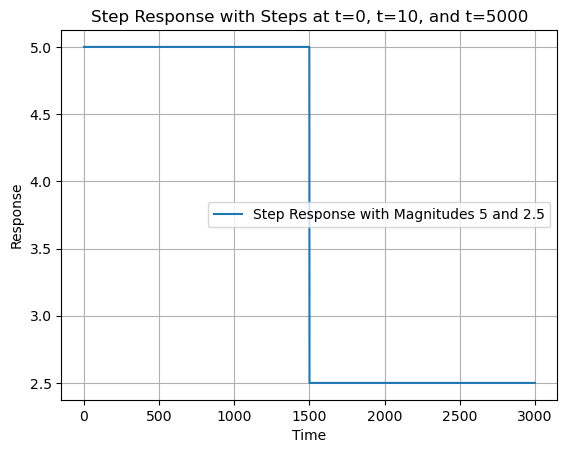

In [26]:
# Parameters
magnitude_1 = 5      # Magnitude of the first step response
magnitude_2 = 2.5    # Magnitude of the second step response
num_points = 3000   # Number of data points

# Time vector (assuming 1 second between each sample)
t = np.linspace(0, 3000, num_points)

# Step response - Starts at 0, jumps to magnitude_1 at t=0, then magnitude_1 again at t=10, and magnitude_2 at t=5000
step_response = np.zeros(num_points)
step_response[t >= 0] = magnitude_1   # First step at t=0
step_response[t >= 10] = magnitude_1  # Second step at t=10
step_response[t >= 1500] = magnitude_2 # Third step at t=5000

# Plot the response
plt.plot(t, step_response, label=f'Step Response with Magnitudes {magnitude_1} and {magnitude_2}')
plt.title(f'Step Response with Steps at t=0, t=10, and t=5000')
plt.xlabel('Time')
plt.ylabel('Response')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
y = sine_wave_y
u = sine_wave_u

In [10]:
input_scaler = MinMaxScaler()
input_scaler.fit(u.reshape(-1, 1))
output_scaler = MinMaxScaler()
output_scaler.fit(y.reshape(-1, 1))

MinMaxScaler()

In [11]:
y_norm = output_scaler.transform(y.reshape(-1, 1)).flatten()
u_norm = input_scaler.transform(u.reshape(-1, 1)).flatten()

In [12]:
y.shape, u.shape, y_norm.shape, u_norm.shape

((10000,), (10000,), (10000,), (10000,))

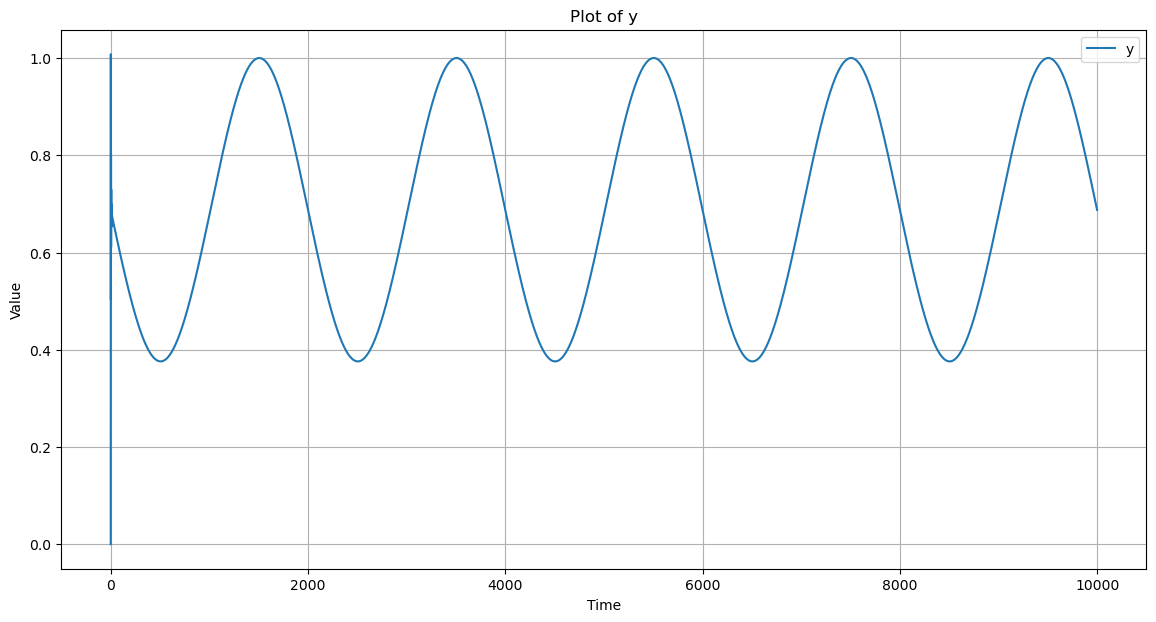

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(y, label='y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of y')
plt.legend()
plt.grid()
plt.show()

In [22]:
y[1:].shape

(9999,)

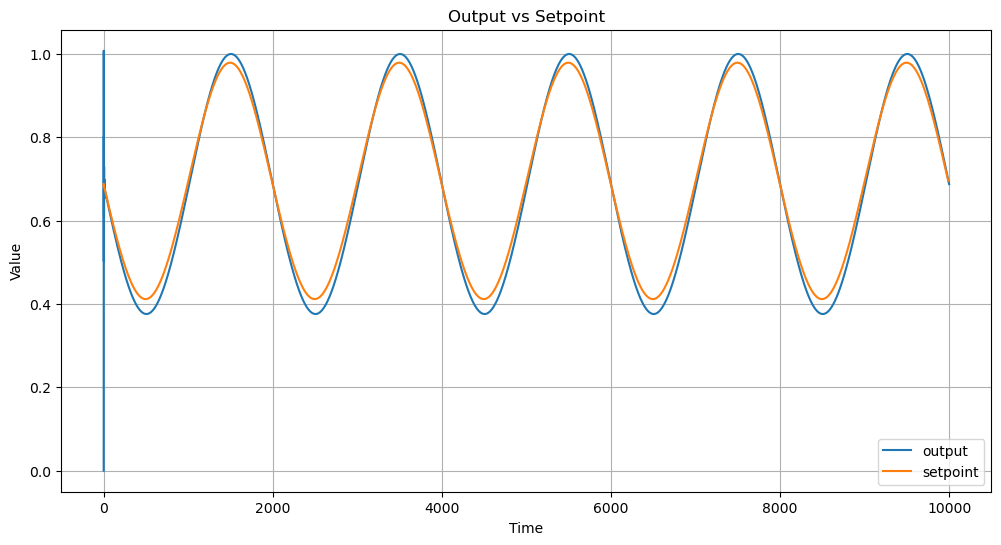

In [32]:
# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(y, label='output')
plt.plot(y[10:]/1.1+0.07, label='setpoint')
plt.title('Output vs Setpoint')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# control loop
plant_X_norm = np.zeros((k_max, 5))
plant_y_norm_pred = np.zeros(k_max)
plant_y_pred = np.zeros(k_max)
ctrl_X_norm = np.zeros((k_max, 5))
ctrl_u_norm_pred = np.zeros(k_max)
ctrl_u_pred = np.zeros(k_max)
error = np.zeros(k_max)
y_ref = y
y_norm_ref = y_norm

for k in range(k_max):

    y_ref_k = y_ref[k]

    if k == 0:
        ctrl_u_norm_pred_k = 0
        ctrl_u_norm_pred_k_1 = 0
        ctrl_u_norm_pred_k_2 = 0
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = 0
        plant_y_norm_pred_k_2 = 0
    if k == 1:
        ctrl_u_norm_pred_k = ctrl_u_norm_pred[k]
        ctrl_u_norm_pred_k_1 = ctrl_u_norm_pred[k-1]
        ctrl_u_norm_pred_k_2 = 0
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = plant_y_norm_pred[k-1]
        plant_y_norm_pred_k_2 = 0
    if k >= 2:
        ctrl_u_norm_pred_k = ctrl_u_norm_pred[k]
        ctrl_u_norm_pred_k_1 = ctrl_u_norm_pred[k-1]
        ctrl_u_norm_pred_k_2 = ctrl_u_norm_pred[k-2]
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = plant_y_norm_pred[k-1]
        plant_y_norm_pred_k_2 = plant_y_norm_pred[k-2]

    ctrl_X_norm_k = np.array([ctrl_u_norm_pred_k_1, ctrl_u_norm_pred_k_2, y_norm_ref_k, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    ctrl_X_norm[k] = ctrl_X_norm_k[0]
    ctrl_u_norm_pred_k = control.predict(ctrl_X_norm_k.reshape(1, -1)).flatten()
    ctrl_u_norm_pred[k] = ctrl_u_norm_pred_k[0]
    ctrl_u_pred_k = input_scaler.inverse_transform(ctrl_u_norm_pred_k.reshape(-1, 1)).flatten()
    ctrl_u_pred[k] = ctrl_u_pred_k[0]

    plant_X_norm_k = np.array([ctrl_u_norm_pred[k], ctrl_u_norm_pred_k_1, ctrl_u_norm_pred_k_2, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    plant_X_norm[k] = plant_X_norm_k
    plant_y_norm_pred_k = plant.predict(plant_X_norm_k.reshape(1, -1)).flatten()
    plant_y_norm_pred[k] = plant_y_norm_pred_k[0]
    plant_y_pred_k = output_scaler.inverse_transform(plant_y_norm_pred_k.reshape(-1, 1)).flatten()
    plant_y_pred[k] = plant_y_pred_k[0]

    error[k] = y_ref_k - plant_y_pred_k[0]

    if k % 10 == 0:
        print(f'k={k}, y_ref={y_ref[k]}, y_pred={plant_y_pred[k]}, error = {error[k]}')

1/1 [==============================] - 0s 51ms/step
k=0, y_ref=0.0, y_pred=0.003669159021228552, error = -0.003669159021228552
1/1 [==============================] - 0s 19ms/step
k=10, y_ref=0.6732921274450356, y_pred=0.20752155780792236, error = 0.4657705696371133
1/1 [==============================] - 0s 20ms/step
k=20, y_ref=0.6684675661857912, y_pred=0.20897889137268066, error = 0.4594886748131105
1/1 [==============================] - 0s 17ms/step
k=30, y_ref=0.658955531135488, y_pred=0.2089618593454361, error = 0.4499936717900519
1/1 [==============================] - 0s 18ms/step
k=40, y_ref=0.6494258225192325, y_pred=0.20894721150398254, error = 0.44047861101525
1/1 [==============================] - 0s 75ms/step
k=50, y_ref=0.6399381650191158, y_pred=0.20893239974975586, error = 0.43100576526935996
1/1 [==============================] - 0s 18ms/step
k=60, y_ref=0.6305012065599522, y_pred=0.20891742408275604, error = 0.4215837824771962
1/1 [==============================] - 0s 

In [ ]:
# control loop
plant_X_norm = np.zeros((k_max, 5))
plant_y_norm_pred = np.zeros(k_max)
plant_y_pred = np.zeros(k_max)
ctrl_X_norm = np.zeros((k_max, 5))
ctrl_u_norm_pred = np.zeros(k_max)
ctrl_u_pred = np.zeros(k_max)
error = np.zeros(k_max)
y_ref = y
y_norm_ref = y_norm

for k in range(1):

    y_ref_k = y_ref[k]

    if k == 0:
        ctrl_u_norm_pred_k = 0
        ctrl_u_norm_pred_k_1 = 0
        ctrl_u_norm_pred_k_2 = 0
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = 0
        plant_y_norm_pred_k_2 = 0
    if k == 1:
        ctrl_u_norm_pred_k = ctrl_u_norm_pred[k]
        ctrl_u_norm_pred_k_1 = ctrl_u_norm_pred[k-1]
        ctrl_u_norm_pred_k_2 = 0
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = plant_y_norm_pred[k-1]
        plant_y_norm_pred_k_2 = 0
    if k >= 2:
        ctrl_u_norm_pred_k = ctrl_u_norm_pred[k]
        ctrl_u_norm_pred_k_1 = ctrl_u_norm_pred[k-1]
        ctrl_u_norm_pred_k_2 = ctrl_u_norm_pred[k-2]
        y_norm_ref_k = y_norm_ref[k]
        plant_y_norm_pred_k_1 = plant_y_norm_pred[k-1]
        plant_y_norm_pred_k_2 = plant_y_norm_pred[k-2]

    ctrl_X_norm_k = np.array([ctrl_u_norm_pred_k_1, ctrl_u_norm_pred_k_2, y_norm_ref_k, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    print(f"ctrl_X_norm_k shape = {ctrl_X_norm_k.shape}")
    ctrl_X_norm[k] = ctrl_X_norm_k[0]
    ctrl_u_norm_pred_k = control.predict(ctrl_X_norm_k.reshape(1, -1)).flatten()
    print(f"ctrl_u_norm_pred_k shape = {ctrl_u_norm_pred_k.shape}")
    print(f"ctrl_u_norm_pred_k_1 shape = {ctrl_u_norm_pred_k_1}")
    print(f"ctrl_u_norm_pred_k_2 shape = {ctrl_u_norm_pred_k_2}")
    ctrl_u_norm_pred[k] = ctrl_u_norm_pred_k[0]
    ctrl_u_pred_k = input_scaler.inverse_transform(ctrl_u_norm_pred_k.reshape(-1, 1)).flatten()
    print(f"ctrl_u_pred_k shape = {ctrl_u_pred_k.shape}")
    ctrl_u_pred[k] = ctrl_u_pred_k[0]
    print(f"ctrl_u_pred_k shape = {ctrl_u_pred_k.shape}")
    print(f"plant_y_norm_pred_k_1 shape = {plant_y_norm_pred_k_1}")
    print(f"plant_y_norm_pred_k_2 shape = {plant_y_norm_pred_k_2}")

    plant_X_norm_k = np.array([ctrl_u_norm_pred[k], ctrl_u_norm_pred_k_1, ctrl_u_norm_pred_k_2, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    print(f"plant_X_norm_k shape = {plant_X_norm_k.shape}")
    plant_X_norm[k] = plant_X_norm_k
    print(f"plant_X_norm shape = {plant_X_norm[k].shape}")
    plant_y_norm_pred_k = plant.predict(plant_X_norm_k.reshape(1, -1)).flatten()
    print(f"plant_y_norm_pred_k shape = {plant_y_norm_pred_k.shape}")
    plant_y_norm_pred[k] = plant_y_norm_pred_k[0]
    print(f"plant_y_norm_pred_k shape = {plant_y_norm_pred_k.shape}")
    plant_y_pred_k = output_scaler.inverse_transform(plant_y_norm_pred_k.reshape(-1, 1)).flatten()
    print(f"plant_y_pred_k shape = {plant_y_pred_k.shape}")
    plant_y_pred[k] = plant_y_pred_k[0]
    print(f"plant_y_pred shape = {plant_y_pred.shape}")

    error[k] = y_ref_k - plant_y_pred_k[0]
    print(f"error shape = {error.shape}")

    # if k % 10 == 0:
    #     print(f'k={k}, y_ref={y_ref[k]}, y_pred={plant_y_pred[k]}, error = {error[k]}')

In [ ]:
# Pre-allocate arrays to store results
plant_X_norm = np.zeros((k_max, 5))
plant_y_norm_pred = np.zeros(k_max)
plant_y_pred = np.zeros(k_max)
ctrl_X_norm = np.zeros((k_max, 5))
ctrl_u_norm_pred = np.zeros(k_max)
ctrl_u_pred = np.zeros(k_max)
error = np.zeros(k_max)

# Use pre-defined references
y_ref = y
y_norm_ref = y_norm

# Initialize control and plant states
ctrl_u_norm_pred_k_1 = 0
ctrl_u_norm_pred_k_2 = 0
ctrl_u_norm_pred_k_3 = 0
plant_y_norm_pred_k_1 = 0
plant_y_norm_pred_k_2 = 0

# Loop through each time step
for k in range(k_max):
    y_ref_k = y_ref[k]
    y_norm_ref_k = y_norm_ref[k]

    # For k >= 3, use previous values
    if k >= 3:
        ctrl_u_norm_pred_k_3 = ctrl_u_norm_pred[k-3]
        ctrl_u_norm_pred_k_2 = ctrl_u_norm_pred[k-2]
        ctrl_u_norm_pred_k_1 = ctrl_u_norm_pred[k-1]
        plant_y_norm_pred_k_2 = plant_y_norm_pred[k-2]
        plant_y_norm_pred_k_1 = plant_y_norm_pred[k-1]
    
    # Construct the feature vector for control system prediction
    ctrl_X_norm_k_1 = np.array([ctrl_u_norm_pred_k_2, ctrl_u_norm_pred_k_3, y_norm_ref_k, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    ctrl_X_norm[k] = ctrl_X_norm_k_1

    # Control system prediction
    ctrl_u_norm_pred_k_1 = control.predict(ctrl_X_norm_k_1.reshape(1, -1)).flatten()
    ctrl_u_norm_pred[k] = ctrl_u_norm_pred_k_1[0]
    ctrl_u_pred_k_1 = input_scaler.inverse_transform(ctrl_u_norm_pred_k_1.reshape(-1, 1)).flatten()
    ctrl_u_pred[k] = ctrl_u_pred_k_1[0]

    # Shift control predictions for next iteration
    ctrl_u_norm_pred_k = ctrl_u_norm_pred_k_1[0]

    # Construct the feature vector for plant prediction
    plant_X_norm_k = np.array([ctrl_u_norm_pred_k, ctrl_u_norm_pred_k_1[0], ctrl_u_norm_pred_k_2, plant_y_norm_pred_k_1, plant_y_norm_pred_k_2])
    plant_X_norm[k] = plant_X_norm_k

    # Plant system prediction
    plant_y_norm_pred_k = plant.predict(plant_X_norm_k.reshape(1, -1)).flatten()
    plant_y_norm_pred[k] = plant_y_norm_pred_k[0]
    plant_y_pred_k = output_scaler.inverse_transform(plant_y_norm_pred_k.reshape(-1, 1)).flatten()
    plant_y_pred[k] = plant_y_pred_k[0]

    # Calculate error between predicted and reference
    error[k] = y_ref_k - plant_y_pred_k[0]

    # Print every 500 iterations for feedback
    if k % 1000 == 0:
        print(f'k={k}, y_ref={y_ref[k]}, y_pred={plant_y_pred[k]}, error = {error[k]}')


In [15]:
y_ref.shape, plant_y_pred.shape

((10000,), (10000,))

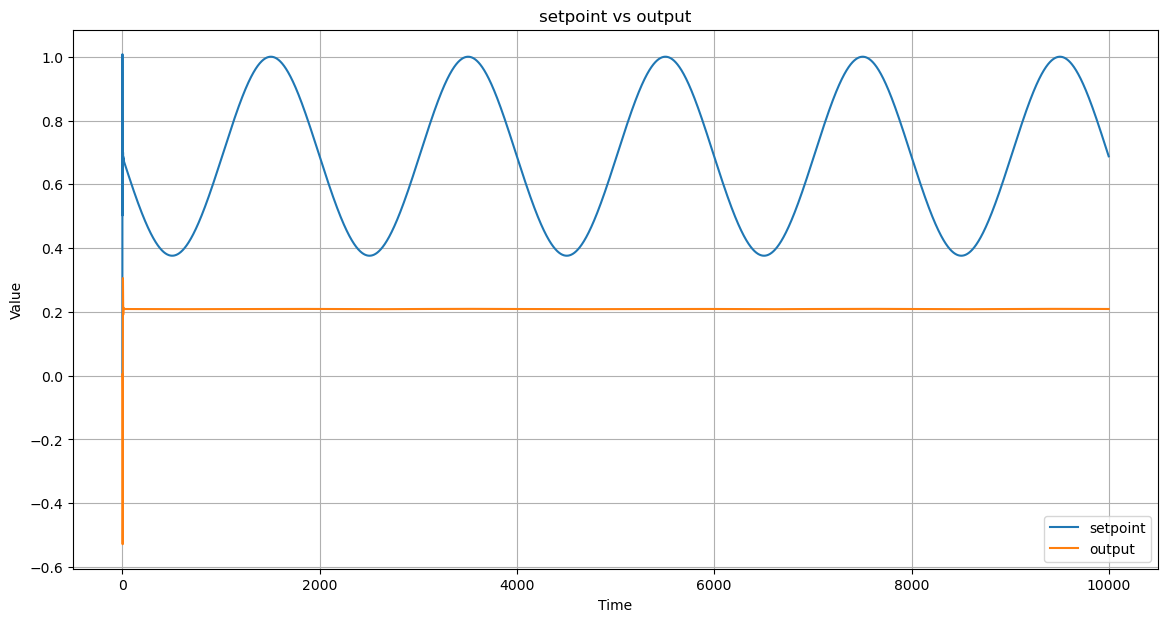

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(y_ref, label='setpoint')
plt.plot(plant_y_pred, label='output')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('setpoint vs output')
plt.legend()
plt.grid()
plt.show()

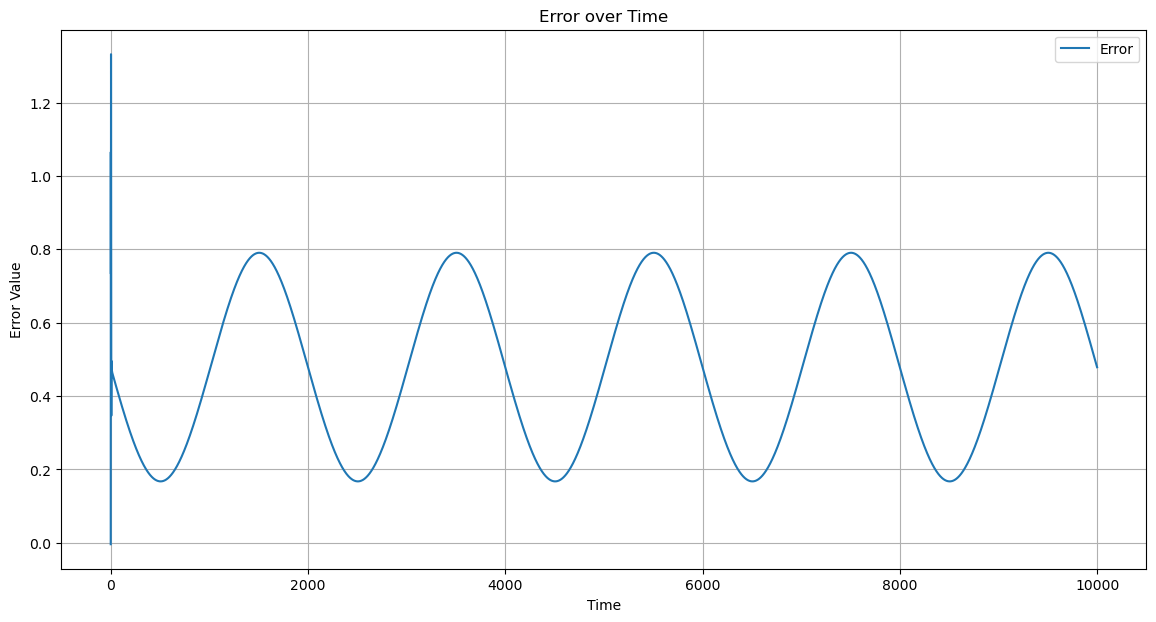

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(error, label='Error')
plt.xlabel('Time')
plt.ylabel('Error Value')
plt.title('Error over Time')
plt.legend()
plt.grid()
plt.show()

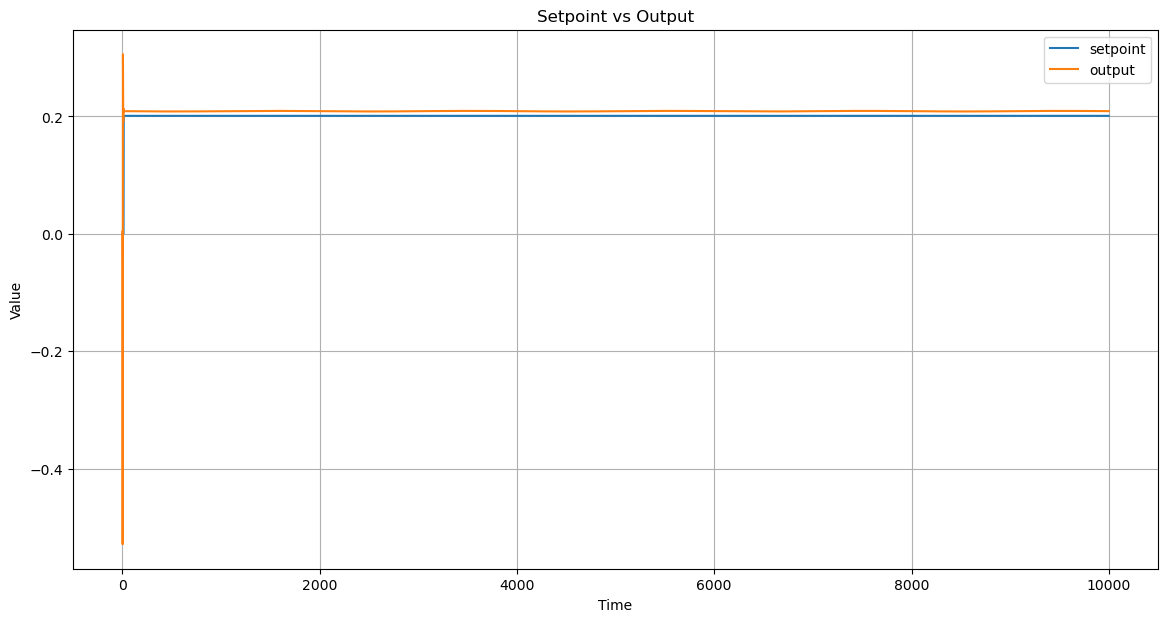

In [42]:
# Define the length of the time axis or match it with plant_y_pred
time = np.arange(len(plant_y_pred))

# Create the setpoint as a constant array with value 0.201
setpoint = np.full_like(plant_y_pred, 0.201)  # A constant value of 0.201 for all time steps

# Set the first 10 elements of the setpoint to 0
setpoint[:13] = 0

# Plot the setpoint vs. output
plt.figure(figsize=(14, 7))
plt.plot(time, setpoint, label='setpoint')
plt.plot(time, plant_y_pred, label='output')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Setpoint vs Output')
plt.legend()
plt.grid()
plt.show()
